In [21]:
import numpy as np
import casadi as ca
from acados_template import AcadosModel, AcadosOcp, AcadosOcpSolver

In [22]:
m = 2.5
g = 9.81
c = 2.0
jx, jy, jz = 2.3, 2.3, 4.5
dx = [1, 1, 1, 1]
dy = [1, 1, 1, 1]
thrust_to_weight = 2.0
max_force_per_motor = (g * m / 4.0) * 2.0
u_min = np.array([0.0, 0.0, 0.0, 0.0])
u_max = np.array([max_force_per_motor, max_force_per_motor, max_force_per_motor, max_force_per_motor])

nodes = 100
t_horizon = 10.0

In [23]:
px, py, pz = ca.MX.sym('px', 1), ca.MX.sym('py', 1), ca.MX.sym('pz', 1)
vx, vy, vz = ca.MX.sym('vx', 1), ca.MX.sym('vy', 1), ca.MX.sym('vz', 1)
qw, qx, qy, qz = ca.MX.sym('qw',1), ca.MX.sym('qx',1), ca.MX.sym('qy',1), ca.MX.sym('qz',1), 
wx, wy, wz = ca.MX.sym('wx', 1), ca.MX.sym('wy', 1), ca.MX.sym('wz', 1)

px_d, py_d, pz_d = ca.MX.sym('px_d', 1), ca.MX.sym('py_d', 1), ca.MX.sym('pz_d', 1)
vx_d, vy_d, vz_d = ca.MX.sym('vx_d', 1), ca.MX.sym('vy_d', 1), ca.MX.sym('vz_d', 1)
qw_d, qx_d, qy_d, qz_d = ca.MX.sym('qw_d',1), ca.MX.sym('qx_d',1), ca.MX.sym('qy_d',1), ca.MX.sym('qz_d',1), 
wx_d, wy_d, wz_d = ca.MX.sym('wx_d', 1), ca.MX.sym('wy_d', 1), ca.MX.sym('wz_d', 1)

u0 = ca.MX.sym('u0')
u1 = ca.MX.sym('u1')
u2 = ca.MX.sym('u2')
u3 = ca.MX.sym('u3')

x_dim = 13
u_dim = 4

x = ca.vertcat(px, py, pz, qw, qx, qy, qz, vx, vy, vz, wx, wy, wz)
xdot = ca.vertcat(px_d, py_d, pz_d, qw_d, qx_d, qy_d, qz_d, vx_d, vy_d, vz_d, wx_d, wy_d, wz_d)
u = ca.vertcat(u0, u1, u2, u3)

In [24]:
f_expl = ca.vertcat(
    vx,
    vy,
    vz,
    0.5 * (-wx*qx - wy*qy - wz*qz),
    0.5 * ( wx*qw + wz*qy - wy*qz),
    0.5 * ( wy*qw - wz*qx + wx*qz),
    0.5 * ( wz*qw + wy*qx - wx*qy),
    (2 * (u0+u1+u2+u3) / m) * (qy*qw + qz*qx),
    (2 * (u0+u1+u2+u3) / m) * (qy*qz - qw*qx),
    ((u0+u1+u2+u3) / m) * (qw*qw - qx*qx - qy*qy +qz*qz) - g,
    (1/jx) * (-dx[0]*u0 - dx[1]*u1 + dx[2]*u2 + dx[3]*u3 - wy*jz*wz + wz*jy*wy),
    (1/jy) * ( dy[0]*u0 - dy[1]*u1 - dy[2]*u2 + dy[3]*u3 - wz*jx*wx + wx*jz*wz),
    (1/jz) * (    -c*u0 +     c*u1 -     c*u2 +     c*u3 - wx*jy*wy + wy*jx*wx)
)

f_impl = xdot - f_expl


In [25]:
model = AcadosModel()
model.f_expl_expr = f_expl
model.f_impl_expr = f_impl
model.x = x
model.xdot = xdot
model.u = u
model.name = "quad_free_flight_model"

In [26]:
ocp = AcadosOcp()
ocp.model = model

In [27]:
weight = np.diag([1, 1, 1,
            0, 0.5, 0.5, 0.5,
            0.5, 0.5, 0.5,
            0.05, 0.05, 0.05,
            0.01, 0.01, 0.01, 0.01])

x0 = np.array([
    1.0, 0.0, 1.0,
    1, 0.0, 0.0, 0.0,
    0.0, 0.0, 0.0,
    0.0, 0.0, 0.0
])

ocp.cost.cost_type = 'LINEAR_LS'
ocp.cost.Vx = np.zeros((x_dim+u_dim, x_dim))
ocp.cost.Vx[:x_dim, :x_dim] = np.eye(x_dim)

ocp.cost.Vu = np.zeros((x_dim+u_dim, u_dim))
ocp.cost.Vu[-u_dim:, -u_dim:] = np.eye(u_dim)

ocp.cost.W = weight

ocp.cost.yref = np.concatenate((x0, np.array([max_force_per_motor/thrust_to_weight, max_force_per_motor/thrust_to_weight, max_force_per_motor/thrust_to_weight, max_force_per_motor/thrust_to_weight])))


In [28]:
ocp.constraints.x0 = x0
ocp.constraints.lbu = u_min
ocp.constraints.ubu = u_max
ocp.constraints.idxbu = np.array([0, 1, 2, 3])

In [29]:
ocp.solver_options.qp_solver = "FULL_CONDENSING_HPIPM"
ocp.solver_options.hessian_approx = "GAUSS_NEWTON"
ocp.solver_options.integrator_type = "ERK"
ocp.solver_options.print_level = 0     # Do not print out
ocp.solver_options.nlp_solver_type = "SQP_RTI"
ocp.solver_options.tf = t_horizon
ocp.solver_options.N_horizon = nodes

In [30]:
acados_ocp_solver = AcadosOcpSolver(ocp)

rm -f libacados_ocp_solver_quad_free_flight_model.so
rm -f acados_solver_quad_free_flight_model.o
cc -fPIC -std=c99   -O2 -I/home/kousheek/Dev/saxion/acados/include -I/home/kousheek/Dev/saxion/acados/include/acados -I/home/kousheek/Dev/saxion/acados/include/blasfeo/include -I/home/kousheek/Dev/saxion/acados/include/hpipm/include  -c -o acados_solver_quad_free_flight_model.o acados_solver_quad_free_flight_model.c
cc -fPIC -std=c99   -O2 -I/home/kousheek/Dev/saxion/acados/include -I/home/kousheek/Dev/saxion/acados/include/acados -I/home/kousheek/Dev/saxion/acados/include/blasfeo/include -I/home/kousheek/Dev/saxion/acados/include/hpipm/include  -c -o quad_free_flight_model_model/quad_free_flight_model_expl_ode_fun.o quad_free_flight_model_model/quad_free_flight_model_expl_ode_fun.c
cc -fPIC -std=c99   -O2 -I/home/kousheek/Dev/saxion/acados/include -I/home/kousheek/Dev/saxion/acados/include/acados -I/home/kousheek/Dev/saxion/acados/include/blasfeo/include -I/home/kousheek/Dev/saxion/acados

186.07444212767845


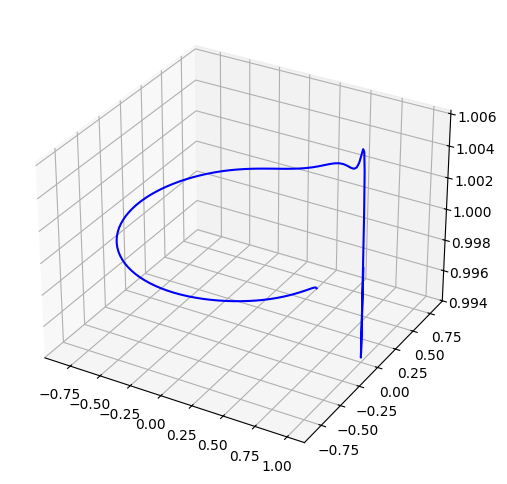

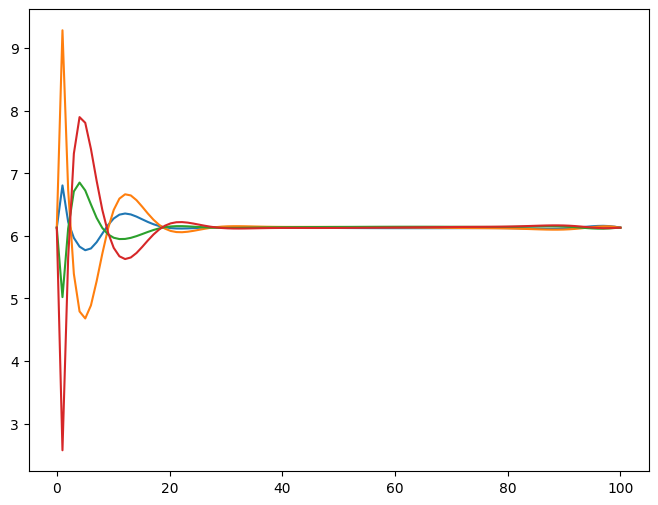

In [33]:
import time

init_time = time.time()
current_state = np.array([1.0, 0.0, 1.0, 
                          1.0, 0.0, 0.0, 0.0, 
                          0.0, 0.0, 0.0,
                          0.0, 0.0, 0.0,])

# reference_state = np.array([1.0, 1.0, 1.0, 
#                           1.0, 0.0, 0.0, 0.0, 
#                           0.0, 0.0, 0.0,
#                           0.0, 0.0, 0.0,
#                           max_force_per_motor/thrust_to_weight, max_force_per_motor/thrust_to_weight, max_force_per_motor/thrust_to_weight, max_force_per_motor/thrust_to_weight])


theta = np.linspace(0, 2 * np.pi, 100)
reference_trajectory = []
for t in theta:
    reference_trajectory.append([np.cos(t), np.sin(t), 1.0, 
                                 1.0, 0.0, 0.0, 0.0, 
                                 0.0, 0.0, 0.0,
                                 0.0, 0.0, 0.0,
                                 max_force_per_motor/thrust_to_weight, max_force_per_motor/thrust_to_weight, max_force_per_motor/thrust_to_weight, max_force_per_motor/thrust_to_weight])
    
reference_trajectory = np.array(reference_trajectory)

# Fill initial state
acados_ocp_solver.set(0, "lbx", current_state)
acados_ocp_solver.set(0, "ubx", current_state)

acados_ocp_solver.set(0, 'lbu', np.array([max_force_per_motor/thrust_to_weight, max_force_per_motor/thrust_to_weight, max_force_per_motor/thrust_to_weight, max_force_per_motor/thrust_to_weight]))
acados_ocp_solver.set(0, 'ubu', np.array([max_force_per_motor/thrust_to_weight, max_force_per_motor/thrust_to_weight, max_force_per_motor/thrust_to_weight, max_force_per_motor/thrust_to_weight]))

for stage in range(ocp.dims.N):
    acados_ocp_solver.set(stage, "y_ref", reference_trajectory[stage])

status = acados_ocp_solver.solve()

print(1/ (time.time() - init_time))

us = []
xs = []

for i in range(100):
    us.append(acados_ocp_solver.get(i, "u"))
    xs.append(acados_ocp_solver.get(i, "x"))

us = np.vstack(us)
xs = np.vstack(xs)

import matplotlib.pyplot as plt

fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')

# Plot the 3D line
ax.plot(xs[:, 0], xs[:, 1], xs[:, 2], label='3D Line', color='b')

# ax.set_xlim(-1, 1)
# ax.set_ylim(-1, 1)
# ax.set_zlim(0, 2)


# Show the plot
plt.show()

t = np.linspace(0, 100, 100)

fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111)

ax.plot(t, us[:, 0], label='f1')
ax.plot(t, us[:, 1], label='f2')
ax.plot(t, us[:, 2], label='f3')
ax.plot(t, us[:, 3], label='f4')


# Show the plot
plt.show()